#AutoNavRL

##Code 1

In [ ]:
import gym
import numpy as np
import random
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# --- Custom Environment ---
class TrafficSignalEnv(gym.Env):
    """
    A simplified traffic signal control environment.
    Observation: Traffic densities in 4 directions [N, E, S, W] (normalized between 0 and 1).
    Action: 0 = keep current signal phase, 1 = switch signal phase.
    Signal phases:
        - Phase 0: North-South green, East-West red.
        - Phase 1: East-West green, North-South red.
    """
    def __init__(self):
        super(TrafficSignalEnv, self).__init__()
        self.action_space = spaces.Discrete(2)  # two actions: keep or switch
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.max_steps = 100
        self.reset()

    def reset(self):
        self.current_phase = 0  # Start with Phase 0: N-S green.
        # Random initial traffic densities for 4 directions.
        self.state = np.random.rand(4)
        self.step_count = 0
        return self.state

    def step(self, action):
        # If action is 1, switch the traffic light phase.
        if action == 1:
            self.current_phase = 1 - self.current_phase

        # Simulate traffic dynamics: each lane's density increases slightly,
        # then decreases if it has a green light.
        new_state = self.state + np.random.uniform(0, 0.1, size=4)
        if self.current_phase == 0:  # Phase 0: N and S have green.
            new_state[0] = max(new_state[0] - 0.2, 0)
            new_state[2] = max(new_state[2] - 0.2, 0)
        else:  # Phase 1: E and W have green.
            new_state[1] = max(new_state[1] - 0.2, 0)
            new_state[3] = max(new_state[3] - 0.2, 0)

        # Clip the state to ensure values remain within [0, 1].
        self.state = np.clip(new_state, 0, 1)

        # Reward is defined as the negative sum of traffic densities (minimize congestion).
        reward = -np.sum(self.state)
        self.step_count += 1
        done = self.step_count >= self.max_steps

        return self.state, reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.step_count}, Phase: {self.current_phase}, Traffic: {self.state}")

# --- DQN Agent ---
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# --- Replay Buffer ---
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

# --- Training Function ---
def train_dqn(env, num_episodes=300):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    policy_net = DQN(input_dim, output_dim).to(device)
    target_net = DQN(input_dim, output_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
    replay_buffer = ReplayBuffer(capacity=10000)

    batch_size = 64
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.05
    epsilon_decay = 0.995
    target_update = 10

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Epsilon-greedy action selection.
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax().item()

            next_state, reward, done, _ = env.step(action)
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(replay_buffer) > batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states = torch.FloatTensor(states).to(device)
                actions = torch.LongTensor(actions).unsqueeze(1).to(device)
                rewards = torch.FloatTensor(rewards).to(device)
                next_states = torch.FloatTensor(next_states).to(device)
                dones = torch.FloatTensor(dones).to(device)

                # Compute Q-values for current states.
                q_values = policy_net(states).gather(1, actions).squeeze(1)

                # Compute target Q-values.
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0]
                    expected_q_values = rewards + gamma * next_q_values * (1 - dones)

                loss = nn.MSELoss()(q_values, expected_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Decay epsilon.
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        # Update target network.
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

    return policy_net

# --- Main ---
if __name__ == "__main__":
    env = TrafficSignalEnv()
    trained_model = train_dqn(env, num_episodes=300)


Episode 0, Total Reward: -28.89, Epsilon: 0.99
Episode 1, Total Reward: -28.73, Epsilon: 0.99
Episode 2, Total Reward: -33.91, Epsilon: 0.99
Episode 3, Total Reward: -47.41, Epsilon: 0.98
Episode 4, Total Reward: -29.60, Epsilon: 0.98
Episode 5, Total Reward: -29.87, Epsilon: 0.97
Episode 6, Total Reward: -41.13, Epsilon: 0.97
Episode 7, Total Reward: -34.88, Epsilon: 0.96
Episode 8, Total Reward: -42.32, Epsilon: 0.96
Episode 9, Total Reward: -25.91, Epsilon: 0.95
Episode 10, Total Reward: -34.74, Epsilon: 0.95
Episode 11, Total Reward: -30.03, Epsilon: 0.94
Episode 12, Total Reward: -51.58, Epsilon: 0.94
Episode 13, Total Reward: -41.69, Epsilon: 0.93
Episode 14, Total Reward: -22.34, Epsilon: 0.93
Episode 15, Total Reward: -39.46, Epsilon: 0.92
Episode 16, Total Reward: -38.95, Epsilon: 0.92
Episode 17, Total Reward: -23.71, Epsilon: 0.91
Episode 18, Total Reward: -28.63, Epsilon: 0.91
Episode 19, Total Reward: -22.40, Epsilon: 0.90
Episode 20, Total Reward: -36.68, Epsilon: 0.90
Ep

Episode 0, Total Reward: -28.78, Epsilon: 0.99
Episode 1, Total Reward: -42.95, Epsilon: 0.99
Episode 2, Total Reward: -37.08, Epsilon: 0.99
Episode 3, Total Reward: -40.30, Epsilon: 0.98
Episode 4, Total Reward: -34.10, Epsilon: 0.98
Episode 5, Total Reward: -44.35, Epsilon: 0.97
Episode 6, Total Reward: -40.73, Epsilon: 0.97
Episode 7, Total Reward: -41.70, Epsilon: 0.96
Episode 8, Total Reward: -35.64, Epsilon: 0.96
Episode 9, Total Reward: -25.16, Epsilon: 0.95
Episode 10, Total Reward: -32.07, Epsilon: 0.95
Episode 11, Total Reward: -28.79, Epsilon: 0.94
Episode 12, Total Reward: -40.64, Epsilon: 0.94
Episode 13, Total Reward: -37.68, Epsilon: 0.93
Episode 14, Total Reward: -40.39, Epsilon: 0.93
Episode 15, Total Reward: -38.27, Epsilon: 0.92
Episode 16, Total Reward: -46.26, Epsilon: 0.92
Episode 17, Total Reward: -36.58, Epsilon: 0.91
Episode 18, Total Reward: -28.88, Epsilon: 0.91
Episode 19, Total Reward: -27.85, Epsilon: 0.90
Episode 20, Total Reward: -36.57, Epsilon: 0.90
Ep

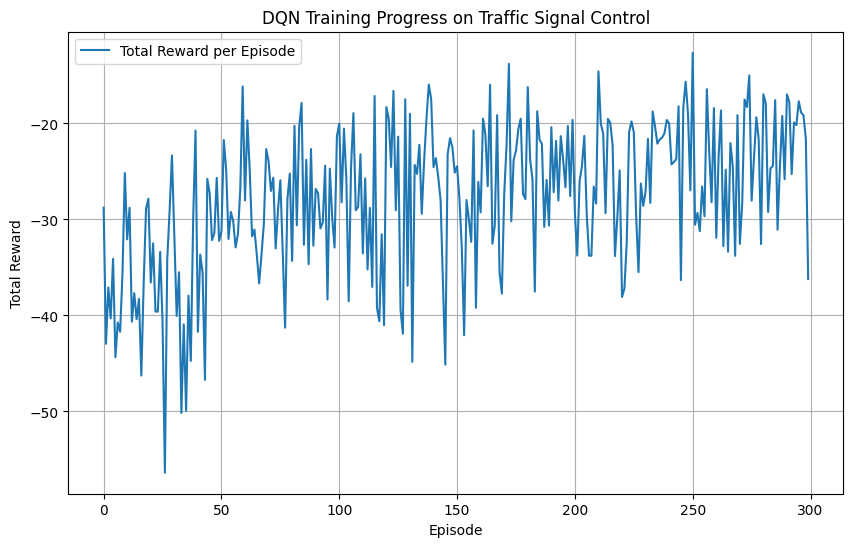

In [ ]:
import gym
import numpy as np
import random
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# --- Custom Environment ---
class TrafficSignalEnv(gym.Env):
    """
    A simplified traffic signal control environment.
    Observation: Traffic densities in 4 directions [N, E, S, W] (normalized between 0 and 1).
    Action: 0 = keep current signal phase, 1 = switch signal phase.
    Signal phases:
        - Phase 0: North-South green, East-West red.
        - Phase 1: East-West green, North-South red.
    """
    def __init__(self):
        super(TrafficSignalEnv, self).__init__()
        self.action_space = spaces.Discrete(2)  # two actions: keep or switch
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.max_steps = 100
        self.reset()

    def reset(self):
        self.current_phase = 0  # Start with Phase 0: N-S green.
        # Random initial traffic densities for 4 directions.
        self.state = np.random.rand(4)
        self.step_count = 0
        return self.state

    def step(self, action):
        # If action is 1, switch the traffic light phase.
        if action == 1:
            self.current_phase = 1 - self.current_phase

        # Simulate traffic dynamics: each lane's density increases slightly,
        # then decreases if it has a green light.
        new_state = self.state + np.random.uniform(0, 0.1, size=4)
        if self.current_phase == 0:  # Phase 0: N and S have green.
            new_state[0] = max(new_state[0] - 0.2, 0)
            new_state[2] = max(new_state[2] - 0.2, 0)
        else:  # Phase 1: E and W have green.
            new_state[1] = max(new_state[1] - 0.2, 0)
            new_state[3] = max(new_state[3] - 0.2, 0)

        # Clip the state to ensure values remain within [0, 1].
        self.state = np.clip(new_state, 0, 1)

        # Reward is defined as the negative sum of traffic densities (minimize congestion).
        reward = -np.sum(self.state)
        self.step_count += 1
        done = self.step_count >= self.max_steps

        return self.state, reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.step_count}, Phase: {self.current_phase}, Traffic: {self.state}")

# --- DQN Agent ---
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# --- Replay Buffer ---
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

# --- Training Function ---
def train_dqn(env, num_episodes=300):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    policy_net = DQN(input_dim, output_dim).to(device)
    target_net = DQN(input_dim, output_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
    replay_buffer = ReplayBuffer(capacity=10000)

    batch_size = 64
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.05
    epsilon_decay = 0.995
    target_update = 10

    episode_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Epsilon-greedy action selection.
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax().item()

            next_state, reward, done, _ = env.step(action)
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(replay_buffer) > batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states = torch.FloatTensor(states).to(device)
                actions = torch.LongTensor(actions).unsqueeze(1).to(device)
                rewards = torch.FloatTensor(rewards).to(device)
                next_states = torch.FloatTensor(next_states).to(device)
                dones = torch.FloatTensor(dones).to(device)

                # Compute Q-values for current states.
                q_values = policy_net(states).gather(1, actions).squeeze(1)

                # Compute target Q-values.
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0]
                    expected_q_values = rewards + gamma * next_q_values * (1 - dones)

                loss = nn.MSELoss()(q_values, expected_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Decay epsilon.
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        # Update target network.
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        episode_rewards.append(total_reward)
        print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

    return policy_net, episode_rewards

# --- Main ---
if __name__ == "__main__":
    env = TrafficSignalEnv()
    trained_model, rewards = train_dqn(env, num_episodes=300)

    # Plotting the training rewards to visualize performance over episodes
    plt.figure(figsize=(10, 6))
    plt.plot(rewards, label="Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("DQN Training Progress on Traffic Signal Control")
    plt.legend()
    plt.grid(True)
    plt.show()


##Code 2

Episode 0, Total Reward: -23.06, Epsilon: 0.99, Actions: [46, 54]
Episode 1, Total Reward: -35.89, Epsilon: 0.99, Actions: [43, 57]
Episode 2, Total Reward: -29.55, Epsilon: 0.99, Actions: [51, 49]
Episode 3, Total Reward: -44.41, Epsilon: 0.98, Actions: [51, 49]
Episode 4, Total Reward: -24.89, Epsilon: 0.98, Actions: [47, 53]
Episode 5, Total Reward: -37.51, Epsilon: 0.97, Actions: [55, 45]
Episode 6, Total Reward: -40.93, Epsilon: 0.97, Actions: [48, 52]
Episode 7, Total Reward: -43.43, Epsilon: 0.96, Actions: [45, 55]
Episode 8, Total Reward: -39.25, Epsilon: 0.96, Actions: [55, 45]
Episode 9, Total Reward: -31.17, Epsilon: 0.95, Actions: [50, 50]
Episode 10, Total Reward: -45.76, Epsilon: 0.95, Actions: [39, 61]
Episode 11, Total Reward: -28.17, Epsilon: 0.94, Actions: [49, 51]
Episode 12, Total Reward: -34.72, Epsilon: 0.94, Actions: [48, 52]
Episode 13, Total Reward: -38.61, Epsilon: 0.93, Actions: [52, 48]
Episode 14, Total Reward: -27.33, Epsilon: 0.93, Actions: [41, 59]
Episo

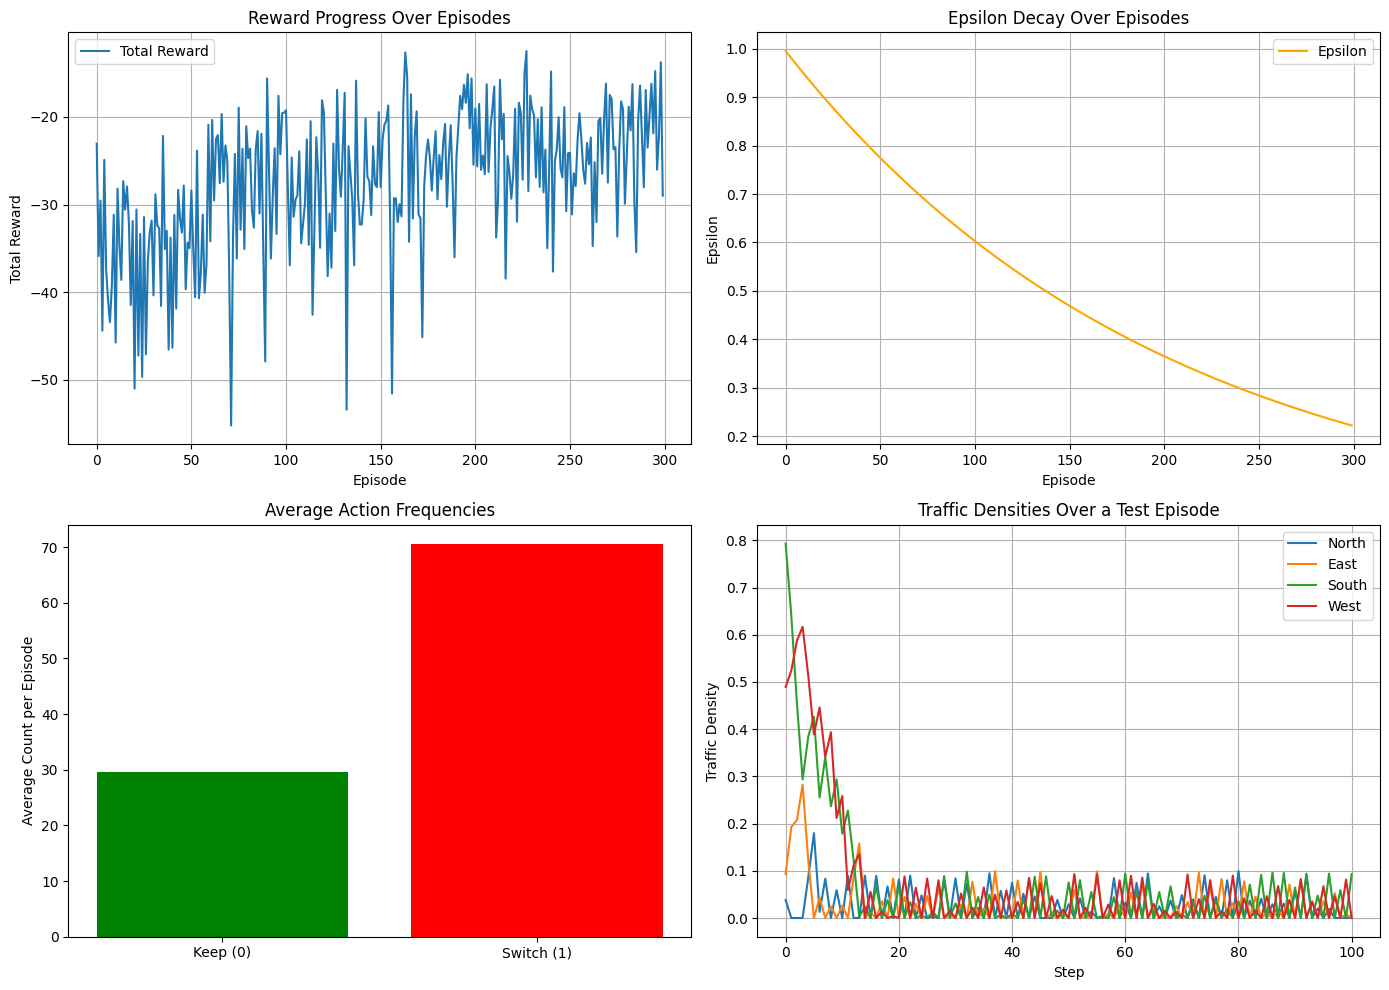

In [ ]:
import gym
import numpy as np
import random
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# --- Custom Environment ---
class TrafficSignalEnv(gym.Env):
    """
    A simplified traffic signal control environment.
    Observation: Traffic densities in 4 directions [N, E, S, W] (normalized between 0 and 1).
    Action: 0 = keep current signal phase, 1 = switch signal phase.
    Signal phases:
        - Phase 0: North-South green, East-West red.
        - Phase 1: East-West green, North-South red.
    """
    def __init__(self):
        super(TrafficSignalEnv, self).__init__()
        self.action_space = spaces.Discrete(2)  # two actions: keep or switch
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.max_steps = 100
        self.reset()

    def reset(self):
        self.current_phase = 0  # Start with Phase 0: N-S green.
        # Random initial traffic densities for 4 directions.
        self.state = np.random.rand(4)
        self.step_count = 0
        return self.state

    def step(self, action):
        # If action is 1, switch the traffic light phase.
        if action == 1:
            self.current_phase = 1 - self.current_phase

        # Simulate traffic dynamics: increase traffic density slightly, then decrease if green.
        new_state = self.state + np.random.uniform(0, 0.1, size=4)
        if self.current_phase == 0:  # Phase 0: N and S have green.
            new_state[0] = max(new_state[0] - 0.2, 0)
            new_state[2] = max(new_state[2] - 0.2, 0)
        else:  # Phase 1: E and W have green.
            new_state[1] = max(new_state[1] - 0.2, 0)
            new_state[3] = max(new_state[3] - 0.2, 0)

        # Clip values to [0, 1].
        self.state = np.clip(new_state, 0, 1)

        # Reward: negative sum of traffic densities (we aim to minimize congestion).
        reward = -np.sum(self.state)
        self.step_count += 1
        done = self.step_count >= self.max_steps

        return self.state, reward, done, {}

    def render(self, mode='human'):
        # Simple text-based rendering.
        print(f"Step: {self.step_count}, Phase: {self.current_phase}, Traffic: {self.state}")

# --- DQN Agent ---
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# --- Replay Buffer ---
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

# --- Training Function ---
def train_dqn(env, num_episodes=300):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    policy_net = DQN(input_dim, output_dim).to(device)
    target_net = DQN(input_dim, output_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
    replay_buffer = ReplayBuffer(capacity=10000)

    batch_size = 64
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.05
    epsilon_decay = 0.995
    target_update = 10

    # Lists to log training metrics.
    episode_rewards = []
    epsilon_history = []
    action_counts_history = []  # [# of 0s, # of 1s] per episode

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        action_counts = [0, 0]  # Count actions: index 0 for action 0, index 1 for action 1

        while not done:
            # Epsilon-greedy action selection.
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax().item()

            action_counts[action] += 1

            next_state, reward, done, _ = env.step(action)
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(replay_buffer) > batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states = torch.FloatTensor(states).to(device)
                actions = torch.LongTensor(actions).unsqueeze(1).to(device)
                rewards = torch.FloatTensor(rewards).to(device)
                next_states = torch.FloatTensor(next_states).to(device)
                dones = torch.FloatTensor(dones).to(device)

                q_values = policy_net(states).gather(1, actions).squeeze(1)
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0]
                    expected_q_values = rewards + gamma * next_q_values * (1 - dones)

                loss = nn.MSELoss()(q_values, expected_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        episode_rewards.append(total_reward)
        epsilon_history.append(epsilon)
        action_counts_history.append(action_counts)
        print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}, Actions: {action_counts}")

    return policy_net, episode_rewards, epsilon_history, action_counts_history

# --- Test Episode Function ---
def run_test_episode(env, model):
    state = env.reset()
    states_over_time = [state.copy()]
    actions_taken = []
    done = False
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    while not done:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = model(state_tensor)
            action = q_values.argmax().item()
        actions_taken.append(action)
        state, _, done, _ = env.step(action)
        states_over_time.append(state.copy())

    return np.array(states_over_time), actions_taken

# --- Main ---
if __name__ == "__main__":
    env = TrafficSignalEnv()
    trained_model, rewards, epsilons, action_counts = train_dqn(env, num_episodes=300)

    # Plotting: Create subplots to visualize multiple aspects.
    episodes = np.arange(len(rewards))

    plt.figure(figsize=(14, 10))

    # Plot Total Reward per Episode.
    plt.subplot(2, 2, 1)
    plt.plot(episodes, rewards, label="Total Reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Reward Progress Over Episodes")
    plt.grid(True)
    plt.legend()

    # Plot Epsilon Decay.
    plt.subplot(2, 2, 2)
    plt.plot(episodes, epsilons, label="Epsilon", color='orange')
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Epsilon Decay Over Episodes")
    plt.grid(True)
    plt.legend()

    # Plot Average Action Counts.
    action_counts = np.array(action_counts)  # shape: (num_episodes, 2)
    avg_action0 = np.mean(action_counts[:, 0])
    avg_action1 = np.mean(action_counts[:, 1])
    plt.subplot(2, 2, 3)
    plt.bar(["Keep (0)", "Switch (1)"], [avg_action0, avg_action1], color=['green', 'red'])
    plt.ylabel("Average Count per Episode")
    plt.title("Average Action Frequencies")

    # Test Episode: Plot traffic densities over time.
    states_over_time, test_actions = run_test_episode(env, trained_model)
    steps = np.arange(states_over_time.shape[0])
    plt.subplot(2, 2, 4)
    plt.plot(steps, states_over_time[:, 0], label="North")
    plt.plot(steps, states_over_time[:, 1], label="East")
    plt.plot(steps, states_over_time[:, 2], label="South")
    plt.plot(steps, states_over_time[:, 3], label="West")
    plt.xlabel("Step")
    plt.ylabel("Traffic Density")
    plt.title("Traffic Densities Over a Test Episode")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
